In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 讀取資料
df = pd.read_csv('data/CA_Weather_Fire_Dataset_1984-2025.csv')

df.head(5)


,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
0,1984-01-01,0.0,79.0,51.0,4.70,False,1984,28.0,0.059494,1,Winter,0.0,4.700,1
1,1984-01-02,0.0,71.0,46.0,5.59,False,1984,25.0,0.078732,1,Winter,0.0,5.145,2
2,1984-01-03,0.0,70.0,47.0,5.37,False,1984,23.0,0.076714,1,Winter,0.0,5.220,3
3,1984-01-04,0.0,76.0,45.0,4.70,False,1984,31.0,0.061842,1,Winter,0.0,5.090,4
4,1984-01-05,0.0,74.0,49.0,5.14,False,1984,25.0,0.069459,1,Winter,0.0,5.100,5


In [2]:
df.describe()


,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
count,14987.000000,14987.000000,14987.000000,14976.000000,14988.000000,14987.000000,14976.000000,14988.000000,14988.000000,14988.000000,14988.000000
mean,0.032315,70.534997,56.494095,7.435098,2004.016813,14.040902,0.107019,6.518281,0.226188,7.434198,182.992994
std,0.179544,7.263447,6.767685,2.129985,11.843342,5.995327,0.035630,3.451037,0.648705,1.387849,105.523627
min,0.000000,50.000000,33.000000,1.790000,1984.000000,2.000000,0.023553,1.000000,0.000000,3.227143,1.000000
25%,0.000000,65.000000,51.000000,6.040000,1994.000000,10.000000,0.085238,4.000000,0.000000,6.518571,92.000000
50%,0.000000,70.000000,57.000000,7.160000,2004.000000,12.000000,0.102222,7.000000,0.000000,7.478571,183.000000
75%,0.000000,75.000000,62.000000,8.500000,2014.000000,17.000000,0.120462,10.000000,0.060000,8.278571,274.000000
max,4.530000,106.000000,77.000000,26.170000,2025.000000,41.000000,0.459123,12.000000,8.180000,13.932857,366.000000


| 欄位名稱               | 說明                                                                 |
|------------------------|----------------------------------------------------------------------|
| DATE                   | 當天的觀測日期                                                       |
| PRECIPITATION          | 每日降水量（英吋）                                                   |
| MAX_TEMP               | 每日最高氣溫（華氏）                                                 |
| MIN_TEMP               | 每日最低氣溫（華氏）                                                 |
| AVG_WIND_SPEED         | 每日平均風速（英里/小時）                                           |
| FIRE_START_DAY         | 是否於該日發生野火（布林值：True/False）                            |
| YEAR                   | 年份                                                                 |
| TEMP_RANGE             | 當日最高與最低溫差，反映氣溫變化程度                                |
| WIND_TEMP_RATIO        | 平均風速與最高溫度的比值，捕捉風與溫度間的動態關係                  |
| MONTH                  | 月份（1–12）                                                        |
| SEASON                 | 季節（Winter, Spring, Summer, Fall）                                |
| LAGGED_PRECIPITATION   | 前 7 天的累積降水量，反映近一週的濕潤條件                            |
| LAGGED_AVG_WIND_SPEED  | 前 7 天的平均風速，反映持續的風力狀況                                |
| DAY_OF_YEAR            | 當年度中的天數（1–365 或 366）                                     |


<h5>

- 對月份做 sin/cos 轉換  保留了數值間的連續性與週期性。
  
- 1 月與 12 月其實很接近，但 get_dummies() 會把它們視為完全無關。

- 而 sin/cos 轉換會保留這種「循環性」。

</h5>

In [3]:
import numpy as np

df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)
df['DOY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_YEAR'] / 366)
df['DOY_COS'] = np.cos(2 * np.pi * df['DAY_OF_YEAR'] / 366)

# 將 FIRE_START_DAY 轉為整數型（0 或 1）
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(int)

<h5>

- `PRECIPITATION`幾乎所有值都是 0（沒下雨），只有極少數是非零，所以我們轉成是否有下雨 

- `TEMP_MEAN` 溫度範圍（TEMP_RANGE）差異滿大的，從 2 到 41，直接用溫度平均值，有時比分開的 MAX、MIN 更有區分力。

</h5>

In [4]:
df['IS_RAINING'] = (df['PRECIPITATION'] > 0).astype(int) #幾乎所有值都是 0（沒下雨），只有極少數是非零。
df['TEMP_MEAN'] = (df['MAX_TEMP'] + df['MIN_TEMP'] / 2).astype(float) #溫度範圍（TEMP_RANGE）差異滿大的，從 2 到 41，直接用溫度平均值，有時比分開的 MAX、MIN 更有區分力。
df = df.drop(columns=['MAX_TEMP', 'MIN_TEMP','LAGGED_PRECIPITATION'])

In [5]:

df.describe()

,PRECIPITATION,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR,MONTH_SIN,MONTH_COS,DOY_SIN,DOY_COS,IS_RAINING,TEMP_MEAN
count,14987.000000,14976.000000,14988.000000,14988.000000,14987.000000,14976.000000,14988.000000,14988.000000,14988.000000,1.498800e+04,1.498800e+04,1.498800e+04,14988.000000,14988.000000,14987.000000
mean,0.032315,7.435098,0.331665,2004.016813,14.040902,0.107019,6.518281,7.434198,182.992994,-4.336929e-03,-1.308696e-03,8.899901e-05,-0.001207,0.092140,98.782044
std,0.179544,2.129985,0.470827,11.843342,5.995327,0.035630,3.451037,1.387849,105.523627,7.056530e-01,7.085902e-01,7.075638e-01,0.706696,0.289234,9.773213
min,0.000000,1.790000,0.000000,1984.000000,2.000000,0.023553,1.000000,3.227143,1.000000,-1.000000e+00,-1.000000e+00,-9.999632e-01,-1.000000,0.000000,68.500000
25%,0.000000,6.040000,0.000000,1994.000000,10.000000,0.085238,4.000000,6.518571,92.000000,-8.660254e-01,-8.660254e-01,-7.101350e-01,-0.704066,0.000000,91.500000
50%,0.000000,7.160000,0.000000,2004.000000,12.000000,0.102222,7.000000,7.478571,183.000000,-2.449294e-16,-1.836970e-16,1.224647e-16,-0.008583,0.000000,99.000000
75%,0.000000,8.500000,1.000000,2014.000000,17.000000,0.120462,10.000000,8.278571,274.000000,5.000000e-01,8.660254e-01,7.101350e-01,0.704066,0.000000,105.500000
max,4.530000,26.170000,1.000000,2025.000000,41.000000,0.459123,12.000000,13.932857,366.000000,1.000000e+00,1.000000e+00,9.999632e-01,1.000000,1.000000,141.000000


- 根據[NOAA](https://www.noaa.gov/noaa-wildfire)
- 和[Climate](https://www.climate.gov/news-features/event-tracker/weather-and-climate-influences-january-2025-fires-around-los-angeles)

- 1. 氣溫變異指數（Temperature Variation Index）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 每日氣溫的變異程度，反映當天最高和最低氣溫之間的差異。較大的溫差可能與氣候極端性相關，進一步加劇火災風險。 |
| **公式**      | `TEMP_VARIATION = MAX_TEMP - MIN_TEMP`                                                     |

- 2. 降水與風速比率（Precipitation-Wind Ratio）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 衡量降水量與風速之間的關聯。當降水量低且風速高時，通常意味著乾燥條件與強風並存，火災風險上升。            |
| **公式**      | `PRECIPITATION_WIND_RATIO = PRECIPITATION / AVG_WIND_SPEED`                                |

- 3. 季節性降水與風速關聯指數（Seasonal Precipitation-Wind Index）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 綜合考量季節（SEASON）對降水與風速影響的指標。不同季節降水和風速的組合，會對火災風險產生不同作用。          |
| **公式**      | `SEASONAL_PRECIP_WIND = (PRECIPITATION * (SEASON == 'Winter')) + (AVG_WIND_SPEED * (SEASON == 'Summer'))` |

- 4. 季節性乾燥指數（Seasonal Dryness Index）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 根據當季（秋季或冬季）的降水量與日溫差來評估乾燥程度。乾燥季節中的高乾燥值與火災風險高度相關。             |
| **公式**      | `SEASONAL_DRYNESS = (PRECIPITATION * (SEASON == 'Fall' or SEASON == 'Winter')) / (MAX_TEMP - MIN_TEMP)` |

- 5. 日中溫差與風速結合指數（Diurnal Temperature and Wind Speed Index） 

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 此指標將每日的氣溫差（即日間溫度變化）與風速結合，評估乾燥和高風速的條件下，火災風險的潛在性。            |
| **公式**      | `DIURNAL_TEMP_WIND = (MAX_TEMP - MIN_TEMP) * AVG_WIND_SPEED` |


In [6]:
#--------------------------------------
# 我分析而得的衍生指標 :
'''



df['PRECIPITATION_WIND_RATIO'] = df['PRECIPITATION'] / df['AVG_WIND_SPEED']
df['SEASONAL_PRECIP_WIND'] = (df['PRECIPITATION'] * (df['SEASON'] == 'Winter')) + (df['AVG_WIND_SPEED'] * (df['SEASON'] == 'Summer'))
df['SEASONAL_DRYNESS'] = (df['PRECIPITATION'] * ((df['SEASON'] == 'Fall') | (df['SEASON'] == 'Winter'))) / (df['MAX_TEMP'] - df['MIN_TEMP'])
df['DIURNAL_TEMP_WIND'] = (df['MAX_TEMP'] - df['MIN_TEMP']) * df['AVG_WIND_SPEED']

'''

# One-Hot Encoding: SEASON
df = pd.get_dummies(df, columns=['SEASON'])
season_cols = ['SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter']
df[season_cols] = df[season_cols].astype(int)

In [7]:
LSdf = df
df = df.drop(columns=['DATE', 'MONTH', 'DAY_OF_YEAR'])

In [8]:
# 特徵與目標分離
X = df.drop(['FIRE_START_DAY'], axis=1)
y = df['FIRE_START_DAY']

In [9]:
print(X.isna().sum())
X = X.fillna(X.median())
assert X.isna().sum().sum() == 0, "There are still missing values in the dataset."

PRECIPITATION             1
AVG_WIND_SPEED           12
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
LAGGED_AVG_WIND_SPEED     0
MONTH_SIN                 0
MONTH_COS                 0
DOY_SIN                   0
DOY_COS                   0
IS_RAINING                0
TEMP_MEAN                 1
SEASON_Fall               0
SEASON_Spring             0
SEASON_Summer             0
SEASON_Winter             0
dtype: int64


2. 數值特徵標準化（Standardization）
為避免某些欄位（如溫度或風速）對模型訓練造成不公平的權重，我們可以對所有數值特徵做 **Z-score** 標準化 **（均值為0，標準差為1）**，但不包含 One-Hot 欄位。

In [10]:
'''
from sklearn.preprocessing import StandardScaler

# 找出所有數值欄位（排除 one-hot 和目標變數）
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# 建立標準化物件並套用於訓練集和測試集
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
'''

"\nfrom sklearn.preprocessing import StandardScaler\n\n# 找出所有數值欄位（排除 one-hot 和目標變數）\nnumeric_cols = X.select_dtypes(include=['float64', 'int64']).columns\n\n# 建立標準化物件並套用於訓練集和測試集\nscaler = StandardScaler()\nX[numeric_cols] = scaler.fit_transform(X[numeric_cols])\n"

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14988 entries, 0 to 14987
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRECIPITATION          14988 non-null  float64
 1   AVG_WIND_SPEED         14988 non-null  float64
 2   YEAR                   14988 non-null  int64  
 3   TEMP_RANGE             14988 non-null  float64
 4   WIND_TEMP_RATIO        14988 non-null  float64
 5   LAGGED_AVG_WIND_SPEED  14988 non-null  float64
 6   MONTH_SIN              14988 non-null  float64
 7   MONTH_COS              14988 non-null  float64
 8   DOY_SIN                14988 non-null  float64
 9   DOY_COS                14988 non-null  float64
 10  IS_RAINING             14988 non-null  int64  
 11  TEMP_MEAN              14988 non-null  float64
 12  SEASON_Fall            14988 non-null  int64  
 13  SEASON_Spring          14988 non-null  int64  
 14  SEASON_Summer          14988 non-null  int64  
 15  SE

### 切割資料集

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [13]:
print(y.value_counts(normalize=True))

FIRE_START_DAY
0    0.668335
1    0.331665
Name: proportion, dtype: float64


In [14]:
X_train.head(5) 

,PRECIPITATION,AVG_WIND_SPEED,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,LAGGED_AVG_WIND_SPEED,MONTH_SIN,MONTH_COS,DOY_SIN,DOY_COS,IS_RAINING,TEMP_MEAN,SEASON_Fall,SEASON_Spring,SEASON_Summer,SEASON_Winter
11798,0.0,7.61,2016,22.0,0.093951,8.277143,0.866025,-0.500000,0.944489,-0.328542,0,110.5,0,1,0,0
4885,0.0,8.50,1997,11.0,0.114865,7.414286,0.500000,-0.866025,0.710135,-0.704066,0,105.5,0,1,0,0
1572,0.0,8.50,1988,14.0,0.132812,10.674286,0.866025,-0.500000,0.938710,-0.344707,0,89.0,0,1,0,0
12985,0.0,10.07,2019,9.0,0.139861,8.245714,-0.500000,-0.866025,-0.320423,-0.947274,0,103.5,0,0,1,0
879,0.0,8.05,1986,11.0,0.113380,7.350000,0.500000,-0.866025,0.551102,-0.834438,0,101.0,0,1,0,0


In [15]:
import mlflow
from mlflow.tracking.client import MlflowClient
mlflow.set_experiment("CA_Weather_Fire1")

<Experiment: artifact_location='file:///c:/Users/ygz08/Desktop/Git/localgit/MLOPs/Predictable_wildfire/mlruns/965674666610152778', creation_time=1746366518514, experiment_id='965674666610152778', last_update_time=1746366518514, lifecycle_stage='active', name='CA_Weather_Fire1', tags={}>

<hr>

## LogisticRegression

In [16]:
from sklearn.linear_model import LogisticRegression

with mlflow.start_run(run_name='LogisticRegression'):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    max_iter=1000 
    #mlflow.log_param("max_iter", max_iter) #mlflow紀錄參數n_estimators
# 方法四：使用 class_weight='balanced'
    log_reg = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    log_reg.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", log_reg.score(X_train, y_train))
    print("Test score:", log_reg.score(X_test, y_test))

    mlflow.log_metric("Train score", log_reg.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", log_reg.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "LogisticRegression-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=log_reg, 
        artifact_path="LogisticRegression-model",
        registered_model_name=model_name,  #
    )

    from sklearn.metrics import classification_report
    report_dict = classification_report(y_test, log_reg.predict(X_test), output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model saved in run 3ac13a61cb834e4087dbe10579ab493d
Train score: 0.7499761700505195
Test score: 0.7511674449633089


2025/05/04 22:43:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'0': {'precision': 0.8843700159489634, 'recall': 0.7279291106005907, 'f1-score': 0.7985598559855985, 'support': 3047.0}, '1': {'precision': 0.5832076420311715, 'recall': 0.8, 'f1-score': 0.674614713579529, 'support': 1450.0}, 'accuracy': 0.7511674449633089, 'macro avg': {'precision': 0.7337888289900674, 'recall': 0.7639645553002954, 'f1-score': 0.7365872847825637, 'support': 4497.0}, 'weighted avg': {'precision': 0.7872640692776718, 'recall': 0.7511674449633089, 'f1-score': 0.7585953337510419, 'support': 4497.0}}


Registered model 'LogisticRegression-model' already exists. Creating a new version of this model...
Created version '18' of model 'LogisticRegression-model'.


<hr>

## Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run(run_name='RandomForest'):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    #max_iter=1000 
    #mlflow.log_param("max_iter", max_iter) #mlflow紀錄參數n_estimators
# 方法四：使用 class_weight='balanced'
    #rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf = RandomForestClassifier(n_estimators=150, max_depth=15, class_weight='balanced')
    rf.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", rf.score(X_train, y_train))
    print("Test score:", rf.score(X_test, y_test))

    mlflow.log_metric("Train score", rf.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", rf.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "RandomForest-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=rf, 
        artifact_path="RandomForest-model",
        registered_model_name=model_name,  #
    )
    
    from sklearn.metrics import classification_report
    report_dict = classification_report(y_test, rf.predict(X_test), output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)


Model saved in run cda651772bfd4567bc58d93b581a1a70
Train score: 0.9478600705366504
Test score: 0.7911941294196131


2025/05/04 22:43:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForest-model' already exists. Creating a new version of this model...
Created version '11' of model 'RandomForest-model'.


{'0': {'precision': 0.8497013934970139, 'recall': 0.8404988513291762, 'f1-score': 0.8450750701204421, 'support': 3047.0}, '1': {'precision': 0.672285906945381, 'recall': 0.6875862068965517, 'f1-score': 0.6798499829526082, 'support': 1450.0}, 'accuracy': 0.7911941294196131, 'macro avg': {'precision': 0.7609936502211975, 'recall': 0.764042529112864, 'f1-score': 0.7624625265365252, 'support': 4497.0}, 'weighted avg': {'precision': 0.7924960442642215, 'recall': 0.7911941294196131, 'f1-score': 0.7918003588922102, 'support': 4497.0}}


### 模型評估 :
- Before Tuning
  - **Train score: 1.0**
  - **Test score: 0.7883033133199912**
  - **accuracy  0.79**

✅ 模型優勢
- 對無火災類別（0）有較高的 precision 和 recall，尤其 recall 高達 0.88，模型能夠準確地識別大部分「無火災」的情況。
- f1-score 達到了 0.85，代表模型對「無火災」的預測表現非常好。

⚠️ 模型的挑戰
- 對有火災（1）類別，precision 是 0.70，而 recall 只有 0.60，這意味著：
    - 對有火災的預測還有進步空間，模型錯過了一部分火災案例，這對於防火系統來說是很關鍵的。

In [18]:
# Tuned Random Forest¶
from sklearn.model_selection import  RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [19]:
# Get the best model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
best_rf = random_search.best_estimator_

# Predict
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("--- Best Random Forest (Tuned) ---")
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_best_rf))

--- Best Random Forest (Tuned) ---
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      3047
           1       0.70      0.65      0.67      1450

    accuracy                           0.80      4497
   macro avg       0.77      0.76      0.76      4497
weighted avg       0.79      0.80      0.79      4497

Confusion Matrix:
 [[2637  410]
 [ 510  940]]
ROC AUC Score: 0.854299423967045


### 結果分析：
- After Tuning
  - **accuracy  0.8**
  - **ROC AUC  0.858**

<hr>

## XG Boosting

In [20]:
from xgboost import XGBClassifier
#Train score: 0.9090649127823849
#Test score: 0.7820769401823437

with mlflow.start_run(run_name='XGBClassifier'):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    max_iter=1000 
    #mlflow.log_param("max_iter", max_iter) #mlflow紀錄參數n_estimators
# 方法四：使用 class_weight='balanced'
    xgb_model = XGBClassifier(
        random_state=42, 
        class_weight='balanced',  # 對不平衡數據進行調整
        alpha=0.1,  # L1 正則化強度，通常設為較小的正值
        lambda_=1.0,  # L2 正則化強度，默認為1
        n_estimators=100,  # 樹的數量
        max_depth=6,  # 每棵樹的最大深度
        learning_rate=0.1  # 學習率
    )
    xgb_model.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", xgb_model.score(X_train, y_train))
    print("Test score:", xgb_model.score(X_test, y_test))

    mlflow.log_metric("Train score", xgb_model.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", xgb_model.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "XGBClassifier-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=xgb_model, 
        artifact_path="XGBClassifier-model",
        registered_model_name=model_name,  #
    )

    from sklearn.metrics import classification_report
    report_dict = classification_report(y_test, xgb_model.predict(X_test), output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:45:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight", "lambda_" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model saved in run 8dd3fe1c826846afb8aacc5ad2f17a13
Train score: 0.8431036126203413
Test score: 0.7949744273960418


2025/05/04 22:45:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBClassifier-model' already exists. Creating a new version of this model...


{'0': {'precision': 0.8380528157811009, 'recall': 0.864456842796193, 'f1-score': 0.8510500807754443, 'support': 3047.0}, '1': {'precision': 0.6949778434268833, 'recall': 0.6489655172413793, 'f1-score': 0.6711840228245364, 'support': 1450.0}, 'accuracy': 0.7949744273960418, 'macro avg': {'precision': 0.7665153296039922, 'recall': 0.7567111800187861, 'f1-score': 0.7611170517999903, 'support': 4497.0}, 'weighted avg': {'precision': 0.791920125117633, 'recall': 0.7949744273960418, 'f1-score': 0.7930545762104417, 'support': 4497.0}}


Created version '12' of model 'XGBClassifier-model'.


### SHAP（SHapley Additive exPlanations）

- 是一種解釋模型預測的工具，告訴你每個特徵對於每一筆資料的預測「貢獻度」。

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 95%|=================== | 4272/4497 [00:12<00:00]       

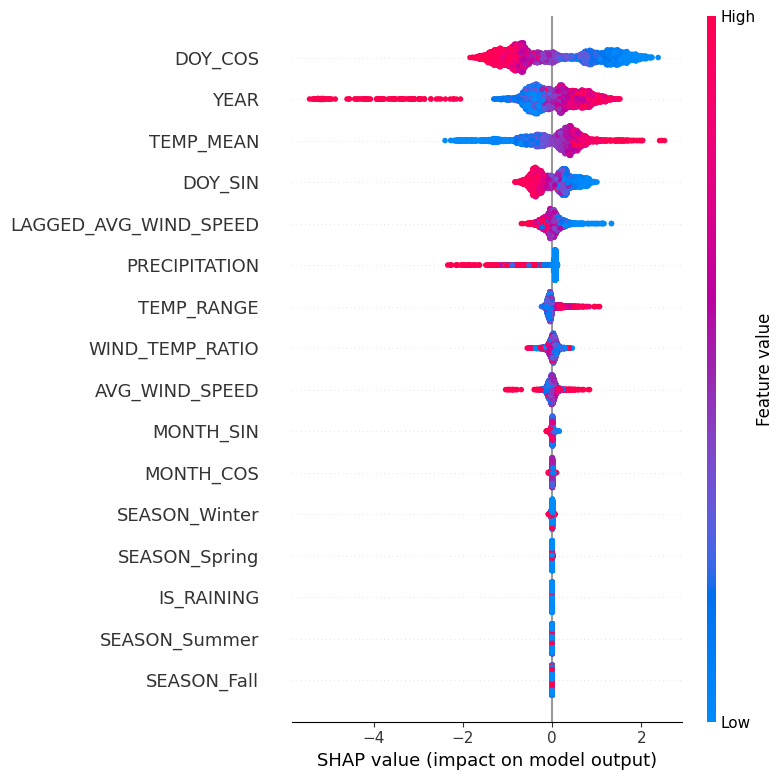

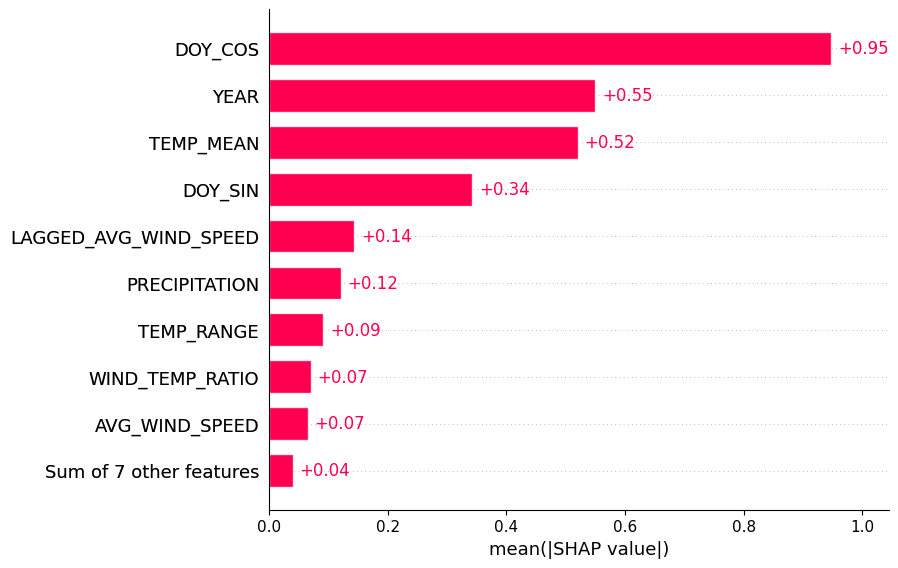

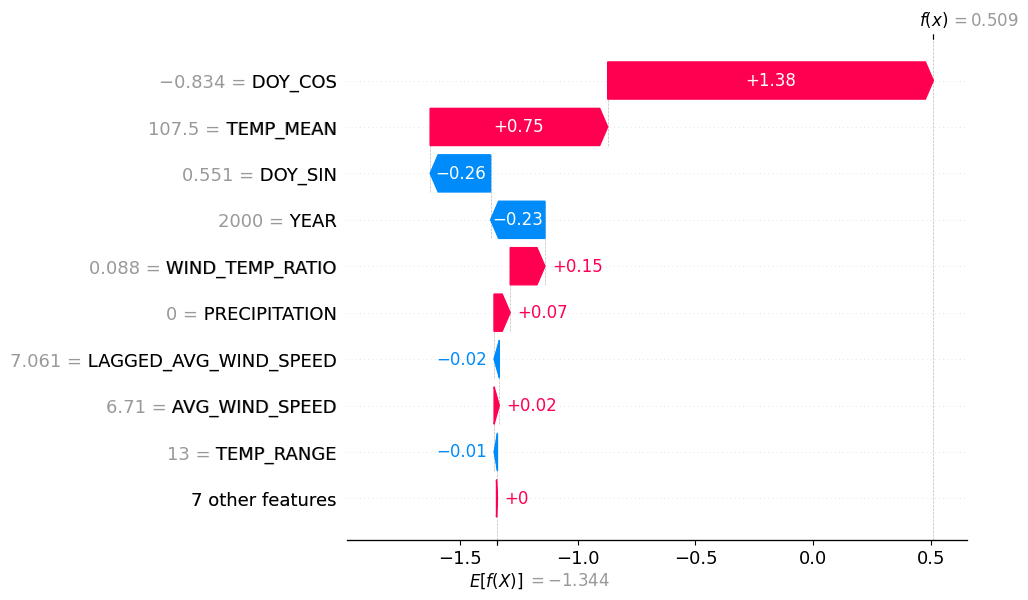

In [21]:
import shap
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot：看整體特徵重要性
shap.summary_plot(shap_values, X_test)

# 2️⃣ Feature importance 排名（平均貢獻度）
shap.plots.bar(shap_values)

# 3️⃣ 解釋單一筆資料（local解釋）
shap.plots.waterfall(shap_values[0])


### 模型評估：

- 精度 (Precision)：對於類別 0（負樣本），精度達到 0.84，對於類別 1（正樣本），精度為 0.70。這意味著模型在預測正樣本時可能有一些錯誤，可能會錯誤地標記一些負樣本為正樣本。

- 召回率 (Recall)：對於類別 0，召回率為 0.87，這是比較好的，說明模型能夠正確標記大部分的負樣本。然而，對於類別 1，召回率是 0.64，意味著有相當一部分的正樣本未被成功預測出來，這可能是過擬合的跡象或者模型對某些特徵不夠敏感。

- F1-score：在平衡精度和召回率後，類別 0 的 F1-score 是 0.85，而類別 1 的 F1-score 是 0.67，這表明模型對於類別 0 的預測表現要好於類別 1。

In [22]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

In [23]:
# 2) Tuned XGBoost via RandomizedSearchCV
param_dist_xgb = {
    'alpha' : [0.0, 0.1, 0.5, 1.0, 2.0],  # L1 正則化強度，通常設為較小的正值
    'lambda_' : [0.0, 0.1, 0.5, 1.0, 2.0],  # L2 正則化強度，默認為1
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5]
}

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
xgb_search.fit(X_train, y_train)

# Get the best model
best_xgb = xgb_search.best_estimator_

# Predict with best model
y_pred_best_xgb = best_xgb.predict(X_test)
y_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:45:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "lambda_", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
print("--- Best XGBoost (Tuned) ---")
print("Best Parameters:", xgb_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_best_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_best_xgb))

--- Best XGBoost (Tuned) ---
Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'lambda_': 0.0, 'gamma': 0.5, 'colsample_bytree': 0.8, 'alpha': 1.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      3047
           1       0.69      0.64      0.67      1450

    accuracy                           0.79      4497
   macro avg       0.77      0.75      0.76      4497
weighted avg       0.79      0.79      0.79      4497

Confusion Matrix:
 [[2636  411]
 [ 517  933]]
ROC AUC Score: 0.8582702035920012


### 結果分析：
- 精度 (Precision)：

    - 類別 0（沒有野火發生） precision: 0.84，這表明大部分被預測為沒有野火的樣本確實是沒有野火。

    - 類別 1（有野火發生） precision: 0.70，這表示模型對於有野火的預測並不如對無野火的預測準確。

- 召回率 (Recall)：

    - 類別 0 recall: 0.87，這說明模型能夠有效地捕捉到大多數沒有野火的樣本。

    - 類別 1 recall: 0.65，這表示對有野火的預測仍然有改進的空間，可能是因為過擬合或特徵選擇不夠充分。

- F1 分數 (F1-Score)：

    - 類別 0 F1-Score: 0.85，這說明對類別 0 的預測效果良好。

    - 類別 1 F1-Score: 0.67，這顯示對類別 1 的預測仍然有提升的空間，可能需要更多針對該類別的特徵或優化。

- ROC AUC Score：0.8619，這是衡量模型區分能力的指標，值較高，說明模型對區分兩類有較好的能力。

<hr>

## DNN

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import regularizers

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# 查看結果
print("Class Weights:", class_weight_dict)

Class Weights: {np.int64(0): np.float64(0.7525824964131994), np.int64(1): np.float64(1.4897756319227493)}


In [27]:
with mlflow.start_run(run_name='DNN'):#mlflow
    mlflow.tensorflow.autolog()#mlflow    

    n_input = X_train.shape[1]

    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(256, input_shape=(n_input,), activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)))  # L2
    model.add(Dropout(0.3))  # 增加 Dropout
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))


    # 模型optimizer 和 learning rate


    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)
    model.summary()

    mlflow.log_param("loss", 'bce') #mlflow
    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])

    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint('./models_temp/DNN_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1, class_weight=class_weight_dict)

    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="DNN-model"              # 註冊後的 model name
    )
    #confusion matrix
    from sklearn.metrics import classification_report
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int) 
    report_dict = classification_report(y_test, y_pred_class, output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)
    
    model.evaluate(X_test, y_test)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

2025/05/04 22:45:50 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential' has no defined input shape yet.
2025/05/04 22:45:50 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/05/04 22:45:50 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
73/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.5853 - Recall: 0.7396 - acc: 0.7327 - loss: 1.0501

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - Precision: 0.5864 - Recall: 0.7452 - acc: 0.7345 - loss: 1.0378 - val_Precision: 0.3224 - val_Recall: 1.0000 - val_acc: 0.3224 - val_loss: 8.7977
Epoch 2/100
72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6149 - Recall: 0.8005 - acc: 0.7545 - loss: 0.7611

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6132 - Recall: 0.7993 - acc: 0.7545 - loss: 0.7562 - val_Precision: 0.3224 - val_Recall: 1.0000 - val_acc: 0.3224 - val_loss: 5.5656
Epoch 3/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6038 - Recall: 0.7972 - acc: 0.7484 - loss: 0.6550

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6034 - Recall: 0.7970 - acc: 0.7487 - loss: 0.6529 - val_Precision: 0.3227 - val_Recall: 1.0000 - val_acc: 0.3233 - val_loss: 2.3420
Epoch 4/100
72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.5842 - Recall: 0.7725 - acc: 0.7502 - loss: 0.5925

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.5857 - Recall: 0.7765 - acc: 0.7503 - loss: 0.5907 - val_Precision: 0.4509 - val_Recall: 0.9345 - val_acc: 0.6120 - val_loss: 0.9721
Epoch 5/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5993 - Recall: 0.7882 - acc: 0.7535 - loss: 0.5577

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.5996 - Recall: 0.7884 - acc: 0.7537 - loss: 0.5576 - val_Precision: 0.5043 - val_Recall: 0.8883 - val_acc: 0.6825 - val_loss: 0.7013
Epoch 6/100
72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6000 - Recall: 0.8013 - acc: 0.7525 - loss: 0.5398

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6001 - Recall: 0.8016 - acc: 0.7528 - loss: 0.5393 - val_Precision: 0.5561 - val_Recall: 0.8345 - val_acc: 0.7318 - val_loss: 0.5904
Epoch 7/100
74/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6300 - Recall: 0.7965 - acc: 0.7691 - loss: 0.5225

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6281 - Recall: 0.7959 - acc: 0.7683 - loss: 0.5228 - val_Precision: 0.5711 - val_Recall: 0.8255 - val_acc: 0.7438 - val_loss: 0.5594
Epoch 8/100
75/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6024 - Recall: 0.8008 - acc: 0.7526 - loss: 0.5245

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6025 - Recall: 0.8004 - acc: 0.7530 - loss: 0.5241 - val_Precision: 0.6008 - val_Recall: 0.7869 - val_acc: 0.7627 - val_loss: 0.5186
Epoch 9/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6219 - Recall: 0.7876 - acc: 0.7672 - loss: 0.5138

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6209 - Recall: 0.7882 - acc: 0.7667 - loss: 0.5141 - val_Precision: 0.6120 - val_Recall: 0.7669 - val_acc: 0.7681 - val_loss: 0.4958
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6117 - Recall: 0.7837 - acc: 0.7596 - loss: 0.5221 - val_Precision: 0.5938 - val_Recall: 0.8014 - val_acc: 0.7592 - val_loss: 0.5258
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6164 - Recall: 0.7951 - acc: 0.7614 - loss: 0.5151 - val_Precision: 0.6178 - val_Recall: 0.7703 - val_acc: 0.7723 - val_loss: 0.5058
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6195 - Recall: 0.7932 - acc: 0.7671 - loss: 0.5043 - val_Precision: 0.6162 - val_Recall: 0.7572 - val_acc: 0.7696 - val_loss: 0.4963
Epoch 13/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.6174 - Recall: 0.7769 - acc: 0.7597 - loss: 0.5096 - val_Precision: 0.6085 - val_Recall: 0.7793 - val_acc: 0.7672 - val_loss: 0.5111
Epoch 14/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6114 - Recall: 0.7973 - acc: 0.7570 - loss: 0.5107 - val_Precision: 0.6303 - val_Recall: 0.7407 - val_acc: 0.7763 - val_loss: 0.4881
Epoch 17/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.6154 - Recall: 0.7874 - acc: 0.7663 - loss: 0.5016 - val_Precision: 0.6111 - val_Recall: 0.7717 - val_acc: 0.7681 - val_loss: 0.5002
Epoch 18/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.6137 - Recall: 0.7827 - acc: 0.7624 - loss: 0.5043 - val_Precision: 0.5884 - val_Recall: 0.8103 - val_acc: 0.7561 - val_loss: 0.5247
Epoch 19/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.6138 - Recall: 0.7877 - acc: 0.7602 - loss: 0.5033 - val_Precision: 0.6001 - val_Recall: 0.7897 - val_acc: 0.7625 - val_loss: 0.5095
Epoch 20/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6193 - Recall: 0.8053 - acc: 0.7705 - loss: 0.4890 - val_Precision: 0.5848 - val_Recall: 0.8014 - val_acc: 0.7525 - val_loss: 0.5286
Epoch 21/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6122 - Recall: 0.7960 - acc: 0.7636 - loss: 0.4973 - val_Precision: 0.6323 - val_Recall: 0.7434 - val_acc: 0.7779 - val_loss: 0.4851
Epoch 48/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6105 - Recall: 0.7751 - acc: 0.7603 - loss: 0.5024 - val_Precision: 0.5871 - val_Recall: 0.8062 - val_acc: 0.7547 - val_loss: 0.5306
Epoch 49/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6231 - Recall: 0.7960 - acc: 0.7628 - loss: 0.5057 - val_Precision: 0.6221 - val_Recall: 0.7731 - val_acc: 0.7754 - val_loss: 0.4942
Epoch 50/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6232 - Recall: 0.7999 - acc: 0.7693 - loss: 0.4964 - val_Precision: 0.6012 - val_Recall: 0.7986 - val_acc: 0.7643 - val_loss: 0.5073
Epoch 51/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6014 - Recall: 0.8040 - acc: 0.7581 - loss: 0.5026 - val_Precision: 0.6001 - val_Recall: 0.7938 - val_acc: 0.7630 - val_loss: 0.5013
Epoch 52/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6068 - Recall: 0.8019 - acc: 0.7616 - loss: 0.4971 - val_Precision: 0.6225 - val_Recall: 0.7655 - val_acc: 0.7747 - val_loss: 0.4849
Epoch 86/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6250 - Recall: 0.7916 - acc: 0.7747 - loss: 0.4851 - val_Precision: 0.5913 - val_Recall: 0.8062 - val_acc: 0.7578 - val_loss: 0.5054
Epoch 87/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6125 - Recall: 0.8233 - acc: 0.7639 - loss: 0.4902 - val_Precision: 0.6077 - val_Recall: 0.7959 - val_acc: 0.7685 - val_loss: 0.5044
Epoch 88/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6129 - Recall: 0.7985 - acc: 0.7682 - loss: 0.4864 - val_Precision: 0.5891 - val_Recall: 0.8138 - val_acc: 0.7569 - val_loss: 0.5156
Epoch 89/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6228 - Recall: 0.8049 - acc: 0.7648 - loss: 0.4961 - val_Precision: 0.6108 - val_Recall: 0.7890 - val_acc: 0.7698 - val_loss: 0.4985
Epoch 90/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6069 - Recall: 0.7964 - acc: 0.7577 - loss: 0.5039 - val_Precision: 0.6188 - val_Recall: 0.7600 - val_acc: 0.7716 - val_loss: 0.4833
Epoch 100/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6279 - Recall: 0.7916 - acc: 0.7708 - loss: 0.4924 - val_Precision: 0.5989 - val_Recall: 0.7917 - val_acc: 0.7618 - val_loss: 0.4957


2025/05/04 22:46:54 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/04 22:46:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/04 22:47:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DNN-model' already exists. Creating a new v

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'0': {'precision': 0.8829457364341086, 'recall': 0.7476206104364949, 'f1-score': 0.8096676737160121, 'support': 3047.0}, '1': {'precision': 0.5988523735002608, 'recall': 0.7917241379310345, 'f1-score': 0.681912681912682, 'support': 1450.0}, 'accuracy': 0.76184122748499, 'macro avg': {'precision': 0.7408990549671847, 'recall': 0.7696723741837647, 'f1-score': 0.745790177814347, 'support': 4497.0}, 'weighted avg': {'precision': 0.7913434735357142, 'recall': 0.76184122748499, 'f1-score': 0.7684747143842735, 'support': 4497.0}}
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.5982 - Recall: 0.7686 - acc: 0.7570 - loss: 0.5031


### 結果分析：
- Recall 提升了不少

    - Recall（靈敏度）高達 ~82%，這對於偵測火災（正類）是好事，表示較少漏判火災發生。

- Precision 稍低，但在接受範圍內

    - Precision 約 57%，代表有一些假陽性，但 Recall 更重要時（例如防災應用），這是可以接受的 trade-off。

- class_weight 有明顯效果




<hr>

## LSTM

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
#準備序列數據 (Prepare sequences)
LSdf = LSdf.drop(columns=['DATE', 'DAY_OF_YEAR']) #刪除不必要的欄位
df_seq = LSdf.sort_values(by=['YEAR', 'MONTH']).reset_index(drop=True)
X_all = df_seq.drop(columns=['YEAR', 'MONTH', 'FIRE_START_DAY'])
X_all = X_all.fillna(X.median())
assert X_all.isna().sum().sum() == 0, "There are still missing values in the dataset."
y_all = df_seq['FIRE_START_DAY']
def create_sequences(X, y, time_steps=12): #時間步長為12
    Xs, ys = [], []
    for i in range(len(X) - time_steps): #(11980, 12, 17) 
        Xs.append(X[i:(i + time_steps)])#(11980, 12, 17)
        ys.append(y[i + time_steps])#(11980,)
    #X[i:(i + time_steps)] 會取出從 i 到 i+time_steps 的資料，這樣就能夠形成一個時間序列的樣本。
    return np.array(Xs), np.array(ys)

#對於每個樣本，Xs 會包含過去12個時刻的特徵，而 ys 會包含12個時間步長後的目標變數。
time_steps  = 12
X_seq, y_seq = create_sequences(X_all, y_all, time_steps=time_steps)

#訓練/測試集切分 (Train/test split)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq,
    test_size=0.2,
    random_state=42,
    stratify=y_seq
)

In [30]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14988 entries, 0 to 14987
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRECIPITATION          14988 non-null  float64
 1   AVG_WIND_SPEED         14988 non-null  float64
 2   TEMP_RANGE             14988 non-null  float64
 3   WIND_TEMP_RATIO        14988 non-null  float64
 4   LAGGED_AVG_WIND_SPEED  14988 non-null  float64
 5   MONTH_SIN              14988 non-null  float64
 6   MONTH_COS              14988 non-null  float64
 7   DOY_SIN                14988 non-null  float64
 8   DOY_COS                14988 non-null  float64
 9   IS_RAINING             14988 non-null  int64  
 10  TEMP_MEAN              14988 non-null  float64
 11  SEASON_Fall            14988 non-null  int64  
 12  SEASON_Spring          14988 non-null  int64  
 13  SEASON_Summer          14988 non-null  int64  
 14  SEASON_Winter          14988 non-null  int64  
dtypes:

In [31]:
import numpy as np
import mlflow
import mlflow.tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# ⚠️ 確保 y 是 numpy array 且為 float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train = X_train.astype(np.float32)

# ⚖️ 計算 class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# 🎯 模型訓練
with mlflow.start_run(run_name='LSTM'):
    mlflow.tensorflow.autolog()

    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
    ])
    model.summary()

    model.compile(loss='bce', optimizer=Adam(learning_rate=0.0005), metrics=['acc', 'Recall', 'Precision'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint('./models_temp/LSTM_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=128,
        callbacks=[early_stop, checkpoint],
        class_weight=class_weight_dict,
        verbose=1
    )

    # 評估
    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="LSTM-model"              # 註冊後的 model name
    )
    
    #confusion matrix
    from sklearn.metrics import classification_report
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int) 
    report_dict = classification_report(y_test, y_pred_class , output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)
    



C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,929 (128.63 KB)

 Trainable params: 32,929 (128.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.4947 - Recall: 0.6137 - acc: 0.6728 - loss: 0.7208
Epoch 1: val_loss improved from inf to 0.61827, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - Precision: 0.4953 - Recall: 0.6147 - acc: 0.6732 - loss: 0.7202 - val_Precision: 0.5888 - val_Recall: 0.7736 - val_acc: 0.7457 - val_loss: 0.6183
Epoch 2/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5993 - Recall: 0.7625 - acc: 0.7545 - loss: 0.5932
Epoch 2: val_loss improved from 0.61827 to 0.60663, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5993 - Recall: 0.7626 - acc: 0.7545 - loss: 0.5930 - val_Precision: 0.5646 - val_Recall: 0.8219 - val_acc: 0.7306 - val_loss: 0.6066
Epoch 3/100
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5910 - Recall: 0.7870 - acc: 0.7447 - loss: 0.5660
Epoch 3: val_loss improved from 0.60663 to 0.57397, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5911 - Recall: 0.7868 - acc: 0.7448 - loss: 0.5658 - val_Precision: 0.5844 - val_Recall: 0.8008 - val_acc: 0.7450 - val_loss: 0.5740
Epoch 4/100
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5891 - Recall: 0.7846 - acc: 0.7485 - loss: 0.5449
Epoch 4: val_loss improved from 0.57397 to 0.52636, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5893 - Recall: 0.7844 - acc: 0.7486 - loss: 0.5450 - val_Precision: 0.6199 - val_Recall: 0.7254 - val_acc: 0.7613 - val_loss: 0.5264
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5907 - Recall: 0.7808 - acc: 0.7468 - loss: 0.5440
Epoch 5: val_loss did not improve from 0.52636
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.5907 - Recall: 0.7808 - acc: 0.7468 - loss: 0.5440 - val_Precision: 0.5846 - val_Recall: 0.7998 - val_acc: 0.7450 - val_loss: 0.5500
Epoch 6/100
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5869 - Recall: 0.7786 - acc: 0.7448 - loss: 0.5403
Epoch 6: val_loss did not improve from 0.52636
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5870 - Recall: 0.7787 - acc: 0.7448 - loss: 0.5402 - val_Precision: 0.5821 - val_Recall: 0.8028 - val_acc: 0.7433 - val_loss: 0.5517
Epoch 7/100
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.6068 - Recall: 0.7825 - acc: 0.7598 - l

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5942 - Recall: 0.7967 - acc: 0.7488 - loss: 0.5243 - val_Precision: 0.6030 - val_Recall: 0.7626 - val_acc: 0.7547 - val_loss: 0.5218
Epoch 11/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5990 - Recall: 0.7995 - acc: 0.7514 - loss: 0.5222
Epoch 11: val_loss did not improve from 0.52181
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.5989 - Recall: 0.7993 - acc: 0.7515 - loss: 0.5222 - val_Precision: 0.5903 - val_Recall: 0.7857 - val_acc: 0.7480 - val_loss: 0.5273
Epoch 12/100
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5867 - Recall: 0.7897 - acc: 0.7428 - loss: 0.5328
Epoch 12: val_loss improved from 0.52181 to 0.51278, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5868 - Recall: 0.7898 - acc: 0.7430 - loss: 0.5325 - val_Precision: 0.6045 - val_Recall: 0.7626 - val_acc: 0.7557 - val_loss: 0.5128
Epoch 13/100
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.6037 - Recall: 0.7929 - acc: 0.7550 - loss: 0.5229
Epoch 13: val_loss did not improve from 0.51278
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - Precision: 0.6035 - Recall: 0.7928 - acc: 0.7549 - loss: 0.5229 - val_Precision: 0.5672 - val_Recall: 0.8239 - val_acc: 0.7330 - val_loss: 0.5560
Epoch 14/100
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5779 - Recall: 0.8009 - acc: 0.7400 - loss: 0.5349
Epoch 14: val_loss did not improve from 0.51278
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.5785 - Recall: 0.8006 - acc: 0.7404 - loss: 0.5344 - val_Precision: 0.5922 - val_Recall: 0.7918 - val_acc: 0.7500 - val_loss: 0.5217
Epoch 15/100
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5867 - Recall: 0.7923 - acc: 0.745

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5853 - Recall: 0.7888 - acc: 0.7493 - loss: 0.5193 - val_Precision: 0.6147 - val_Recall: 0.7465 - val_acc: 0.7607 - val_loss: 0.5047
Epoch 19/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5882 - Recall: 0.7815 - acc: 0.7436 - loss: 0.5282
Epoch 19: val_loss did not improve from 0.50466
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.5882 - Recall: 0.7817 - acc: 0.7437 - loss: 0.5280 - val_Precision: 0.5923 - val_Recall: 0.7907 - val_acc: 0.7500 - val_loss: 0.5234
Epoch 20/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5919 - Recall: 0.7694 - acc: 0.7454 - loss: 0.5312
Epoch 20: val_loss did not improve from 0.50466
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.5919 - Recall: 0.7697 - acc: 0.7455 - loss: 0.5309 - val_Precision: 0.6039 - val_Recall: 0.7545 - val_acc: 0.7543 - val_loss: 0.5067
Epoch 21/100
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5906 - Recall: 0.7793 - acc: 0.749

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - Precision: 0.6024 - Recall: 0.7782 - acc: 0.7568 - loss: 0.5144 - val_Precision: 0.6099 - val_Recall: 0.7425 - val_acc: 0.7570 - val_loss: 0.5034
Epoch 23/100
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.6035 - Recall: 0.7911 - acc: 0.7532 - loss: 0.5206
Epoch 23: val_loss improved from 0.50345 to 0.49462, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6033 - Recall: 0.7912 - acc: 0.7532 - loss: 0.5205 - val_Precision: 0.6338 - val_Recall: 0.7103 - val_acc: 0.7677 - val_loss: 0.4946
Epoch 24/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.6052 - Recall: 0.7814 - acc: 0.7579 - loss: 0.5151
Epoch 24: val_loss did not improve from 0.49462
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6051 - Recall: 0.7814 - acc: 0.7578 - loss: 0.5151 - val_Precision: 0.6049 - val_Recall: 0.7626 - val_acc: 0.7560 - val_loss: 0.5103
Epoch 25/100
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5878 - Recall: 0.7955 - acc: 0.7466 - loss: 0.5242
Epoch 25: val_loss did not improve from 0.49462
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.5883 - Recall: 0.7953 - acc: 0.7469 - loss: 0.5237 - val_Precision: 0.6024 - val_Recall: 0.7485 - val_acc: 0.7527 - val_loss: 0.5094
Epoch 26/100
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.6060 - Recall: 0.7850 - acc: 0.757

Registered model 'LSTM-model' already exists. Creating a new version of this model...
Created version '11' of model 'LSTM-model'.


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'0.0': {'precision': 0.8469713071200851, 'recall': 0.7962037962037962, 'f1-score': 0.8208032955715757, 'support': 2002.0}, '1.0': {'precision': 0.6337522441651705, 'recall': 0.710261569416499, 'f1-score': 0.6698292220113852, 'support': 994.0}, 'accuracy': 0.7676902536715621, 'macro avg': {'precision': 0.7403617756426277, 'recall': 0.7532326828101477, 'f1-score': 0.7453162587914804, 'support': 2996.0}, 'weighted avg': {'precision': 0.7762304030556041, 'recall': 0.7676902536715621, 'f1-score': 0.7707137664931947, 'support': 2996.0}}


<hr>

## Attention mechanism

In [32]:
X = df.drop(['FIRE_START_DAY'], axis=1)
y = df['FIRE_START_DAY']
X = X.fillna(X.median())
assert X.isna().sum().sum() == 0, "There are still missing values in the dataset."
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [33]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, MultiHeadAttention, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model

#
with mlflow.start_run(run_name='AttentionMechanisim'):#mlflow
    mlflow.tensorflow.autolog()#mlflow    
    n_input = X_train.shape[1]
    # Model
    # 定義模型
    input_layer = Input(shape=(n_input,))
    x = BatchNormalization()(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    # Reshape 輸入，以便進行注意力機制（將它變成三維張量）
    x = Reshape((1, 128))(x)  # 假設每個樣本有 128 個特徵，這樣就會有 1 個時間步
    # 添加多頭注意力層
    x_attention = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # query, key 和 value 都是 x
    x_attention = Dropout(0.1)(x_attention)
    # 將注意力層的輸出展平
    x_flattened = Flatten()(x_attention)
    # 經過展平後的處理
    x = Dense(128, activation='relu')(x_flattened)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)


    # Model
    model = Model(inputs=input_layer, outputs=output)
    model.summary()
    # 模型optimizer 和 learning rate
    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])
    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    checkpoint = ModelCheckpoint('./models_temp/attention_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1, callbacks=[early_stop, checkpoint], class_weight=class_weight_dict)

    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="attention-model"              # 註冊後的 model name
    )
    
    #confusion matrix
    from sklearn.metrics import classification_report
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int) 
    report_dict = classification_report(y_test, y_pred_class, output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)


    # 評估模型
    model.evaluate(X_test, y_test)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ input_layer_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      2,176 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 128)    │     66,048 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,929 (331.75 KB)

 Trainable params: 84,897 (331.63 KB)

 Non-trainable params: 32 (128.00 B)

2025/05/04 22:47:59 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/05/04 22:47:59 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5615 - Recall: 0.8034 - acc: 0.7236 - loss: 0.5417
Epoch 1: val_loss improved from inf to 21.44247, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Precision: 0.5619 - Recall: 0.8033 - acc: 0.7239 - loss: 0.5414 - val_Precision: 0.3224 - val_Recall: 1.0000 - val_acc: 0.3224 - val_loss: 21.4425
Epoch 2/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5911 - Recall: 0.8162 - acc: 0.7480 - loss: 0.5017
Epoch 2: val_loss improved from 21.44247 to 3.70909, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5913 - Recall: 0.8159 - acc: 0.7482 - loss: 0.5017 - val_Precision: 0.3224 - val_Recall: 1.0000 - val_acc: 0.3224 - val_loss: 3.7091
Epoch 3/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6004 - Recall: 0.7937 - acc: 0.7591 - loss: 0.4962
Epoch 3: val_loss improved from 3.70909 to 1.52760, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.6007 - Recall: 0.7937 - acc: 0.7590 - loss: 0.4963 - val_Precision: 0.3382 - val_Recall: 0.9979 - val_acc: 0.3696 - val_loss: 1.5276
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6214 - Recall: 0.7996 - acc: 0.7686 - loss: 0.4890
Epoch 4: val_loss improved from 1.52760 to 0.80131, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6212 - Recall: 0.7995 - acc: 0.7685 - loss: 0.4891 - val_Precision: 0.4227 - val_Recall: 0.9621 - val_acc: 0.5642 - val_loss: 0.8013
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6045 - Recall: 0.7945 - acc: 0.7606 - loss: 0.4962 
Epoch 5: val_loss improved from 0.80131 to 0.57862, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6045 - Recall: 0.7946 - acc: 0.7606 - loss: 0.4961 - val_Precision: 0.5290 - val_Recall: 0.8503 - val_acc: 0.7076 - val_loss: 0.5786
Epoch 6/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6118 - Recall: 0.7844 - acc: 0.7644 - loss: 0.4927 
Epoch 6: val_loss improved from 0.57862 to 0.55576, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6118 - Recall: 0.7850 - acc: 0.7642 - loss: 0.4927 - val_Precision: 0.5521 - val_Recall: 0.8400 - val_acc: 0.7287 - val_loss: 0.5558
Epoch 7/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6116 - Recall: 0.7982 - acc: 0.7652 - loss: 0.4881
Epoch 7: val_loss improved from 0.55576 to 0.55481, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6115 - Recall: 0.7979 - acc: 0.7649 - loss: 0.4884 - val_Precision: 0.5529 - val_Recall: 0.8400 - val_acc: 0.7294 - val_loss: 0.5548
Epoch 8/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6006 - Recall: 0.8153 - acc: 0.7598 - loss: 0.4844
Epoch 8: val_loss improved from 0.55481 to 0.53308, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6009 - Recall: 0.8148 - acc: 0.7598 - loss: 0.4846 - val_Precision: 0.5743 - val_Recall: 0.8207 - val_acc: 0.7461 - val_loss: 0.5331
Epoch 9/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6046 - Recall: 0.8058 - acc: 0.7579 - loss: 0.4903
Epoch 9: val_loss improved from 0.53308 to 0.52415, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.6047 - Recall: 0.8056 - acc: 0.7579 - loss: 0.4903 - val_Precision: 0.5859 - val_Recall: 0.8069 - val_acc: 0.7538 - val_loss: 0.5241
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6218 - Recall: 0.8044 - acc: 0.7652 - loss: 0.4901
Epoch 10: val_loss improved from 0.52415 to 0.49908, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.6216 - Recall: 0.8043 - acc: 0.7652 - loss: 0.4901 - val_Precision: 0.5970 - val_Recall: 0.7876 - val_acc: 0.7601 - val_loss: 0.4991
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6133 - Recall: 0.8024 - acc: 0.7628 - loss: 0.4867
Epoch 11: val_loss improved from 0.49908 to 0.47502, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.6133 - Recall: 0.8024 - acc: 0.7628 - loss: 0.4867 - val_Precision: 0.6267 - val_Recall: 0.7434 - val_acc: 0.7745 - val_loss: 0.4750
Epoch 12/100
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6222 - Recall: 0.7756 - acc: 0.7684 - loss: 0.4940
Epoch 12: val_loss did not improve from 0.47502
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - Precision: 0.6220 - Recall: 0.7762 - acc: 0.7683 - loss: 0.4938 - val_Precision: 0.5827 - val_Recall: 0.8138 - val_acc: 0.7521 - val_loss: 0.5141
Epoch 13/100
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6220 - Recall: 0.8024 - acc: 0.7671 - loss: 0.4856
Epoch 13: val_loss did not improve from 0.47502
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6216 - Recall: 0.8020 - acc: 0.7669 - loss: 0.4858 - val_Precision: 0.5959 - val_Recall: 0.7993 - val_acc: 0.7605 - val_loss: 0.4983
Epoch 14/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.6168 - Recall: 0.7992 - acc: 0.7628 

2025/05/04 22:48:24 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/04 22:48:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/04 22:48:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'attention-model' already exists. Creating a

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'0': {'precision': 0.8660424918977314, 'recall': 0.7893009517558254, 'f1-score': 0.8258928571428571, 'support': 3047.0}, '1': {'precision': 0.6267441860465116, 'recall': 0.743448275862069, 'f1-score': 0.6801261829652997, 'support': 1450.0}, 'accuracy': 0.7745163442294863, 'macro avg': {'precision': 0.7463933389721216, 'recall': 0.7663746138089471, 'f1-score': 0.7530095200540784, 'support': 4497.0}, 'weighted avg': {'precision': 0.7888838208983388, 'recall': 0.7745163442294863, 'f1-score': 0.7788922617331488, 'support': 4497.0}}
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6266 - Recall: 0.7152 - acc: 0.7687 - loss: 0.4850
